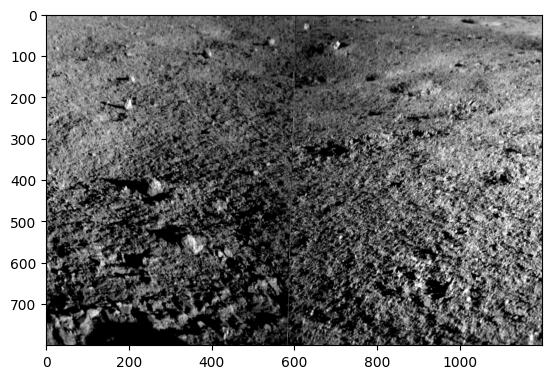

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 

image_path = r'D:\research_implementation\lunar_surface\bird_eye_view_lunarsurface_nogrid.png'
image = cv2.imread(image_path)
plt.imshow(image)


In [4]:
image.shape

(800, 1200, 3)

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate
from tensorflow.keras.models import Model
# Step 1: Load and Preprocess Images
def load_and_preprocess(image_path):
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_normalized = img_gray / 255.0
    img_denoised = cv2.GaussianBlur(img_normalized, (5, 5), 0)
    return img_denoised

# Step 2: Feature Extraction (LBP & Edge Detection)
def extract_features(img):
    lbp = local_binary_pattern(img, P=8, R=1, method="uniform")
    edges = cv2.Canny((img * 255).astype(np.uint8), 100, 200)
    return lbp, edges

# Step 3: Crater Detection using U-Net (Placeholder Model)
def build_unet():
    inputs = Input((800, 1200, 1))
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    
    u1 = UpSampling2D((2, 2))(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c3)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 4: Terrain Classification using CNN (ResNet50 Transfer Learning)
def build_resnet_classifier():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    output = Dense(3, activation='softmax')(x)  # 3 terrain classes
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model






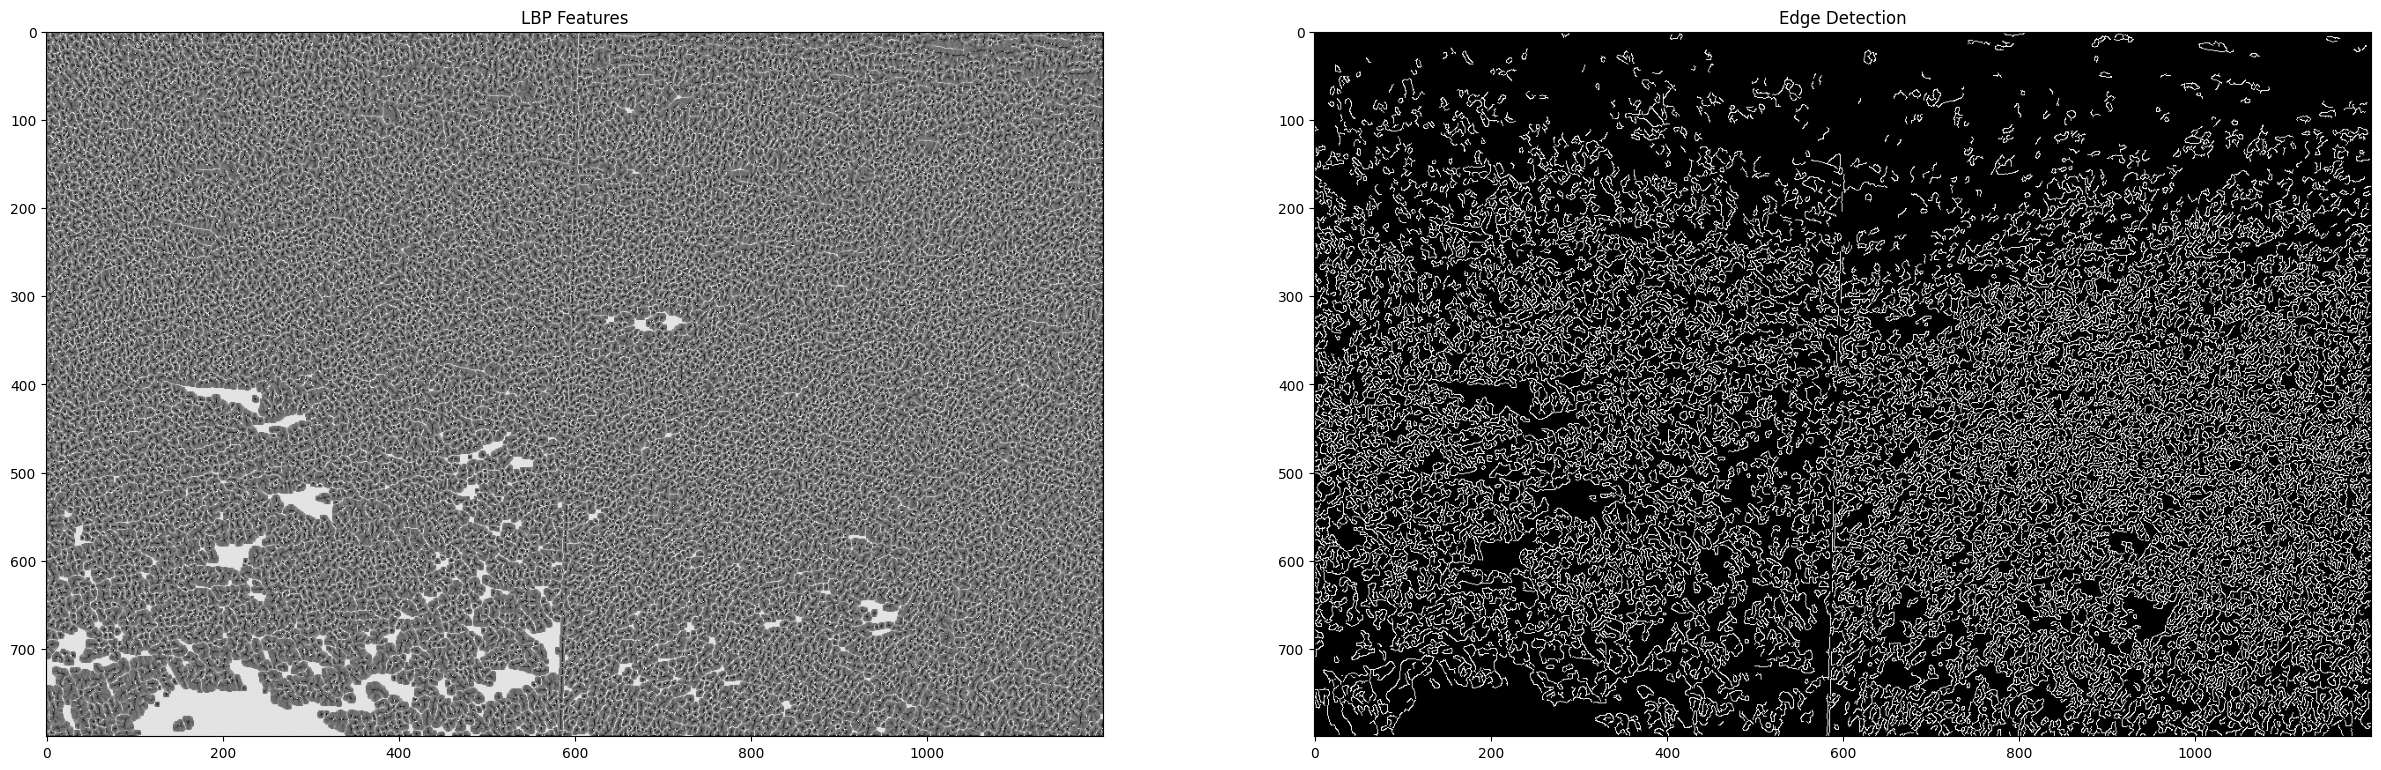

In [7]:



img_processed = load_and_preprocess(image_path)
lbp_features, edge_map = extract_features(img_processed)

# Plot Results
plt.figure(figsize=(30,50))
plt.subplot(1,2,1)
plt.title("LBP Features")
plt.imshow(lbp_features, cmap='gray')
plt.subplot(1,2,2)
plt.title("Edge Detection")
plt.imshow(edge_map, cmap='gray')
plt.show()

In [8]:
print(lbp_features)
print(edge_map)

[[1. 1. 0. ... 2. 2. 3.]
 [3. 3. 4. ... 3. 2. 1.]
 [9. 5. 5. ... 5. 4. 0.]
 ...
 [2. 4. 4. ... 4. 5. 3.]
 [2. 3. 3. ... 4. 4. 3.]
 [0. 1. 2. ... 2. 2. 3.]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Reference Grid Points:
 [[  0.   0.]
 [500.   0.]
 [500. 500.]
 [  0. 500.]]
Terrain Points:
 [[ 390.  270.]
 [1650.  270.]
 [1950. 1020.]
 [ 150. 1020.]]
Homography Matrix:
 [[ 2.52000000e+00 -5.70000000e-01  3.90000000e+02]
 [ 6.59103314e-18  8.88000000e-01  2.70000000e+02]
 [ 1.02186560e-20 -6.00000000e-04  1.00000000e+00]]


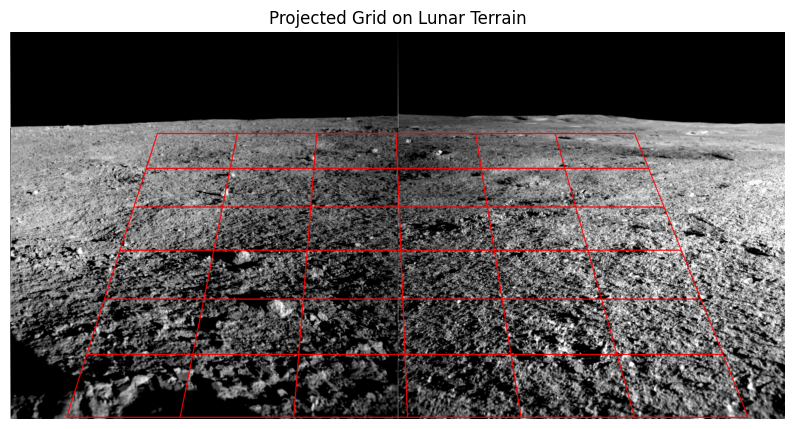

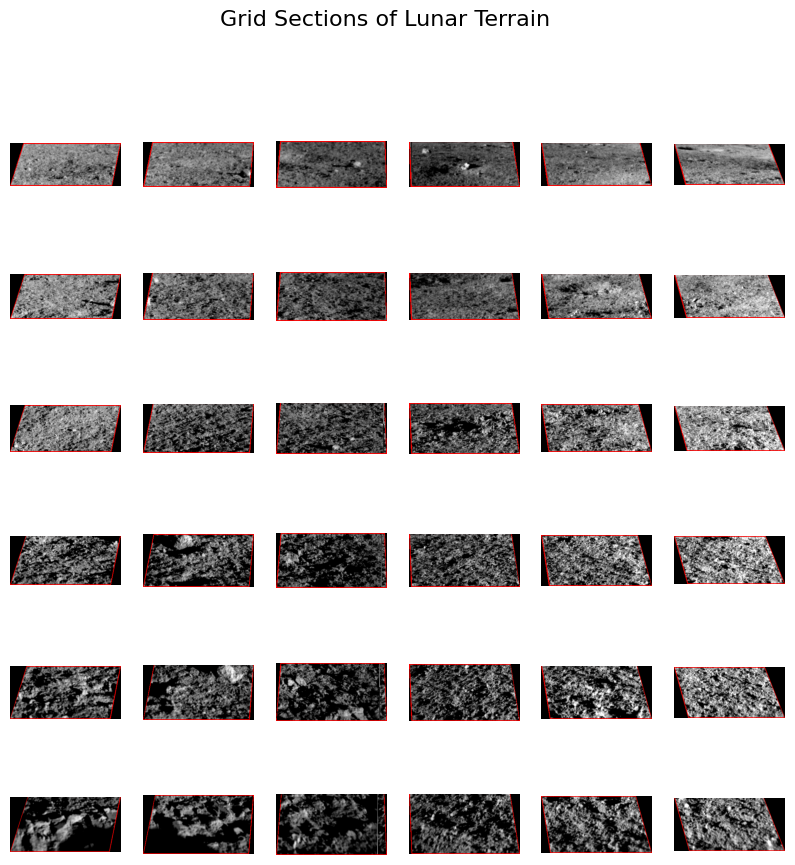

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the lunar surface image
image_path = r"D:\research_implementation\lunar_surface\merged_image.png"

image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not found. Check the path.")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ------------------------------
# 1️⃣ Define Manually Selected Terrain Points
# ------------------------------
terrain_points = np.array([
    [390, 270],  # Top-left
    [1650, 270],
      [1950, 1020]   ,
    [150, 1020],  # Bottom-right
], dtype=np.float32)

# ------------------------------
# 2️⃣ Define a Regular Grid for Mapping
# ------------------------------
grid_width = 500
grid_height = 500

reference_grid = np.array([
    [0, 0],               # Top-left
    [grid_width, 0],      # Top-right
    [grid_width, grid_height],  # Bottom-right
    [0, grid_height]      # Bottom-left
], dtype=np.float32)

# Debug: Print Point Correspondences
print("Reference Grid Points:\n", reference_grid)
print("Terrain Points:\n", terrain_points)

# ------------------------------
# 3️⃣ Compute Homography
# ------------------------------
H, status = cv2.findHomography(reference_grid, terrain_points)

if H is None:
    raise ValueError("Homography computation failed. Ensure points correspond correctly.")

print("Homography Matrix:\n", H)

# ------------------------------
# 4️⃣ Draw Grid on Image
# ------------------------------
grid_size = 6  # Grid resolution
for i in range(grid_size + 1):
    try:
        # Vertical lines
        pt1 = np.dot(H, np.array([i * grid_width / grid_size, 0, 1]))
        pt2 = np.dot(H, np.array([i * grid_width / grid_size, grid_height, 1]))
        pt1 = (int(pt1[0] / pt1[2]), int(pt1[1] / pt1[2]))
        pt2 = (int(pt2[0] / pt2[2]), int(pt2[1] / pt2[2]))
        cv2.line(image, pt1, pt2, (255, 0, 0), 2)

        # Horizontal lines
        pt3 = np.dot(H, np.array([0, i * grid_height / grid_size, 1]))
        pt4 = np.dot(H, np.array([grid_width, i * grid_height / grid_size, 1]))
        pt3 = (int(pt3[0] / pt3[2]), int(pt3[1] / pt3[2]))
        pt4 = (int(pt4[0] / pt4[2]), int(pt4[1] / pt4[2]))
        cv2.line(image, pt3, pt4, (255, 0, 0), 2)
    except:
        print(f"Skipping line {i} due to invalid transformation.")

# Show the image with the grid
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("off")
plt.title("Projected Grid on Lunar Terrain")
plt.show()

# visualize the each grid section
# Visualize each grid section separately
fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for i in range(grid_size):
    for j in range(grid_size):
        # Define the corners of the grid cell
        pt1 = np.dot(H, np.array([j * grid_width / grid_size, i * grid_height / grid_size, 1]))
        pt2 = np.dot(H, np.array([(j + 1) * grid_width / grid_size, i * grid_height / grid_size, 1]))
        pt3 = np.dot(H, np.array([(j + 1) * grid_width / grid_size, (i + 1) * grid_height / grid_size, 1]))
        pt4 = np.dot(H, np.array([j * grid_width / grid_size, (i + 1) * grid_height / grid_size, 1]))

        # Normalize points
        pts = np.array([
            [int(pt1[0] / pt1[2]), int(pt1[1] / pt1[2])],
            [int(pt2[0] / pt2[2]), int(pt2[1] / pt2[2])],
            [int(pt3[0] / pt3[2]), int(pt3[1] / pt3[2])],
            [int(pt4[0] / pt4[2]), int(pt4[1] / pt4[2])]
        ], dtype=np.int32)

        # Create a mask for the grid cell
        mask = np.zeros_like(image[:, :, 0])
        cv2.fillPoly(mask, [pts], 255)

        # Extract the grid cell using the mask
        grid_section = cv2.bitwise_and(image, image, mask=mask)
        x, y, w, h = cv2.boundingRect(pts)
        grid_section = grid_section[y:y+h, x:x+w]

        # Display the grid section
        axs[i, j].imshow(grid_section)
        axs[i, j].axis("off")

plt.suptitle("Grid Sections of Lunar Terrain", fontsize=16)
plt.show()

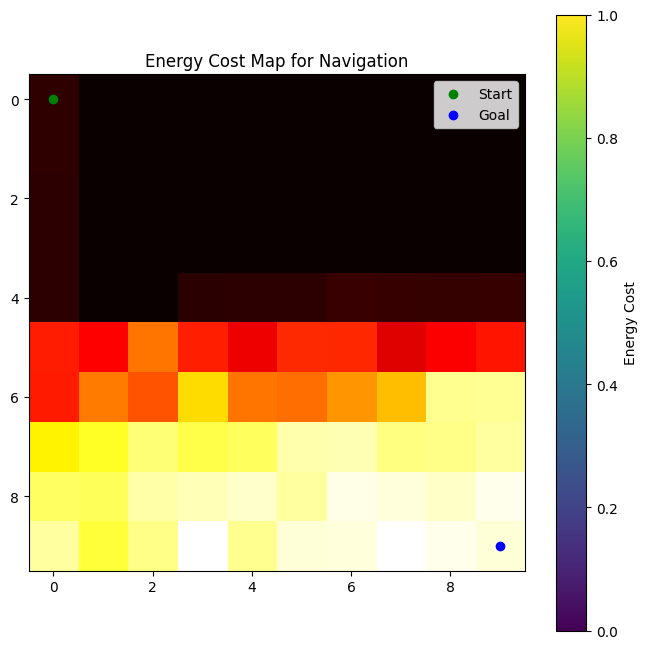

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from scipy.ndimage import sobel

# Load image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Define grid size
grid_size = 10  # 10x10 grid
grid_width, grid_height = 500, 500  # Reference grid

# Compute LPB features
radius = 1
n_points = 8 * radius
lbp = local_binary_pattern(image, n_points, radius, method="uniform")

# Compute edge map
edges = cv2.Canny(image, 100, 200)

# Define cost map
cost_map = np.zeros((grid_size, grid_size))

# Compute energy cost per grid cell
cell_w, cell_h = grid_width // grid_size, grid_height // grid_size

for i in range(grid_size):
    for j in range(grid_size):
        x1, y1 = j * cell_w, i * cell_h
        x2, y2 = (j + 1) * cell_w, (i + 1) * cell_h

        # Extract region from LBP and Edge Map
        region_lbp = lbp[y1:y2, x1:x2]
        region_edges = edges[y1:y2, x1:x2]

        # Compute average values
        avg_lbp = np.mean(region_lbp)
        avg_edges = np.mean(region_edges)

        # Assign energy cost (weighted sum)
        cost_map[i, j] = 0.5 * avg_lbp + 0.5 * avg_edges

# Normalize cost map
cost_map = (cost_map - cost_map.min()) / (cost_map.max() - cost_map.min())

# Define start and goal positions
start_pos = (0, 0)
goal_pos = (grid_size - 1, grid_size - 1)

# Display Energy Cost Map
plt.figure(figsize=(8, 8))
plt.imshow(cost_map, cmap="hot", interpolation="nearest")
plt.scatter(start_pos[1], start_pos[0], color="green", label="Start")
plt.scatter(goal_pos[1], goal_pos[0], color="blue", label="Goal")
plt.colorbar(label="Energy Cost")
plt.title("Energy Cost Map for Navigation")
plt.legend()
plt.show()


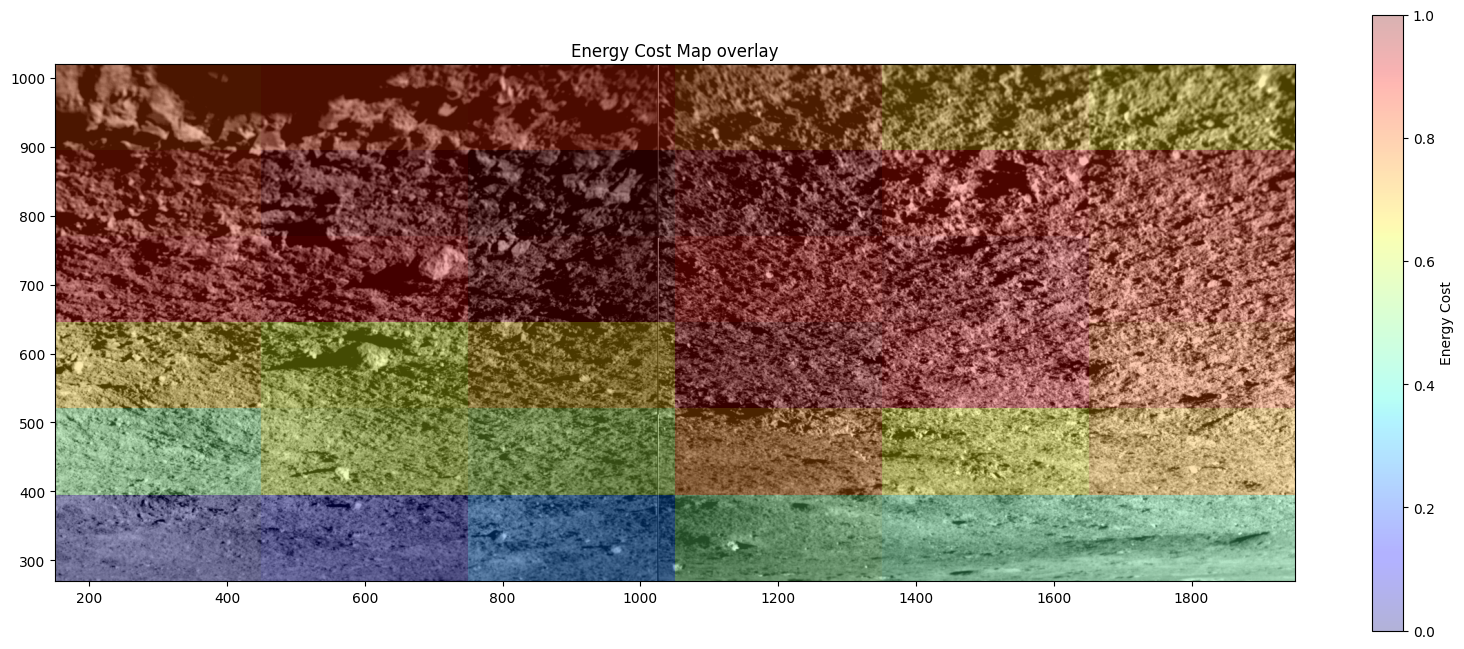

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

# Load the lunar surface image
image_path = r"D:\research_implementation\lunar_surface\merged_image.png"
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not found. Check the path.")

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

# Define terrain and reference grid
terrain_points = np.array([[390, 270], [1650, 270], [1950, 1020], [150, 1020]], dtype=np.float32)
grid_size = 6  # Grid resolution
grid_width, grid_height = 500, 500

reference_grid = np.array([[0, 0], [grid_width, 0], [grid_width, grid_height], [0, grid_height]], dtype=np.float32)

# Compute Homography
H, _ = cv2.findHomography(reference_grid, terrain_points)

# Energy cost matrix (6x6 grid)
energy_cost = np.zeros((grid_size, grid_size))

# Compute energy cost for each grid cell
for i in range(grid_size):
    for j in range(grid_size):
        # Define the four corners of the grid cell
        pt1 = np.dot(H, np.array([j * grid_width / grid_size, i * grid_height / grid_size, 1]))
        pt2 = np.dot(H, np.array([(j + 1) * grid_width / grid_size, i * grid_height / grid_size, 1]))
        pt3 = np.dot(H, np.array([(j + 1) * grid_width / grid_size, (i + 1) * grid_height / grid_size, 1]))
        pt4 = np.dot(H, np.array([j * grid_width / grid_size, (i + 1) * grid_height / grid_size, 1]))

        # Normalize points
        pts = np.array([
            [int(pt1[0] / pt1[2]), int(pt1[1] / pt1[2])],
            [int(pt2[0] / pt2[2]), int(pt2[1] / pt2[2])],
            [int(pt3[0] / pt3[2]), int(pt3[1] / pt3[2])],
            [int(pt4[0] / pt4[2]), int(pt4[1] / pt4[2])]
        ], dtype=np.int32)

        # Create mask and extract grid region
        mask = np.zeros_like(image)
        cv2.fillPoly(mask, [pts], 255)
        grid_section = cv2.bitwise_and(image, image, mask=mask)
        x, y, w, h = cv2.boundingRect(pts)
        grid_section = grid_section[y:y+h, x:x+w]

        # Compute LPB feature for texture analysis
        if grid_section.size > 0:
            lbp = local_binary_pattern(grid_section, P=8, R=1, method="uniform")
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)
            texture_score = np.sum(lbp_hist * np.arange(len(lbp_hist)))  # Weighted sum for texture intensity

            # Compute edge density
            edges = cv2.Canny(grid_section, 50, 150)
            edge_density = np.sum(edges) / (w * h + 1)  # Normalize edge count

            # Energy cost (higher for rougher terrain)
            energy_cost[i, j] = (texture_score * 0.6 + edge_density * 0.4) * 100

# Normalize energy cost
energy_cost = (energy_cost - np.min(energy_cost)) / (np.max(energy_cost) - np.min(energy_cost))

# Plot Energy Cost Map
plt.figure(figsize=(20, 8))
plt.imshow(image, cmap="gray")
plt.imshow(energy_cost, cmap="jet", alpha=0.3, extent=[terrain_points[:, 0].min(), terrain_points[:, 0].max(),
                                                        terrain_points[:, 1].min(), terrain_points[:, 1].max()])
plt.colorbar(label="Energy Cost")
plt.title("Energy Cost Map overlay")
plt.show()



C:\Users\ASUS\AppData\Local\Temp\ipykernel_6568\3154134898.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


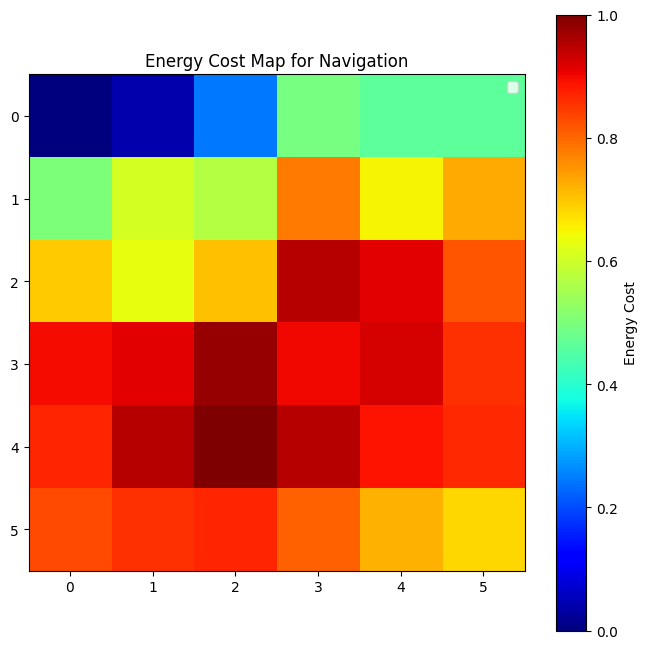

In [2]:
# Display Energy Cost Map
plt.figure(figsize=(8, 8))
plt.imshow(np.flip(energy_cost,0), cmap="jet")
# plt.scatter(start_pos[1], start_pos[0], color="green", label="Start")
# plt.scatter(goal_pos[1], goal_pos[0], color="blue", label="Goal")
plt.colorbar(label="Energy Cost")
plt.title("Energy Cost Map for Navigation")
plt.legend()
plt.show()

In [3]:
energy_cost = np.flip(energy_cost,0)
print(energy_cost)

[[0.         0.04277713 0.24311663 0.49470234 0.46368594 0.46379897]
 [0.50223527 0.60647121 0.56991673 0.77890135 0.65087462 0.72998675]
 [0.69357809 0.63251866 0.70333501 0.95006792 0.91024824 0.81895411]
 [0.89544802 0.91301993 0.97772431 0.89844197 0.92461879 0.85710395]
 [0.8677406  0.95105498 1.         0.95264647 0.88683092 0.86433875]
 [0.83120665 0.85904648 0.86740642 0.80785085 0.72221092 0.6821429 ]]


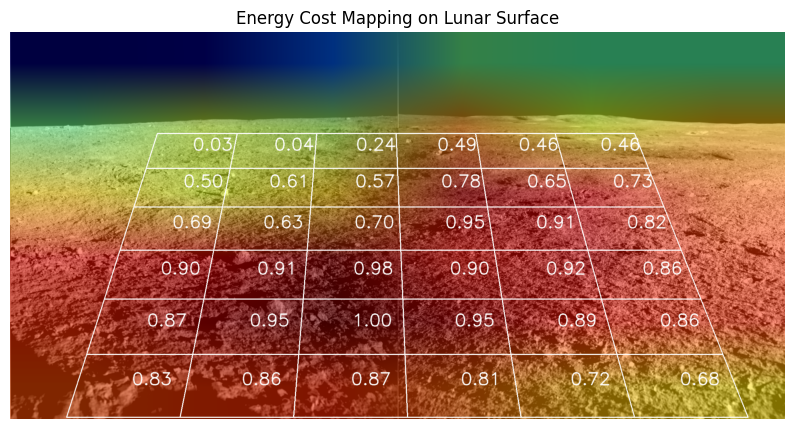

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the lunar surface image
image_path = r"D:\research_implementation\lunar_surface\merged_image.png"
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not found. Check the path.")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Energy cost values for the 6x6 grid
energy_cost = np.array([
    [0.83120665, 0.85904648, 0.86740642, 0.80785085, 0.72221092, 0.6821429],
    [0.8677406, 0.95105498, 1., 0.95264647, 0.88683092, 0.86433875],
    [0.89544802, 0.91301993, 0.97772431, 0.89844197, 0.92461879, 0.85710395],
    [0.69357809, 0.63251866, 0.70333501, 0.95006792, 0.91024824, 0.81895411],
    [0.50223527, 0.60647121, 0.56991673, 0.77890135, 0.65087462, 0.72998675],
    [0.03, 0.04277713, 0.24311663, 0.49470234, 0.46368594, 0.46379897]
])
energy_cost = np.flip(energy_cost, 0)
# ------------------------------
# Define Homography
# ------------------------------
terrain_points = np.array([
    [390, 270],  # Top-left
    [1650, 270],
    [1950, 1020],
    [150, 1020],  # Bottom-left
], dtype=np.float32)

grid_width, grid_height = 500, 500
reference_grid = np.array([
    [0, 0],
    [grid_width, 0],
    [grid_width, grid_height],
    [0, grid_height]
], dtype=np.float32)

H, _ = cv2.findHomography(reference_grid, terrain_points)
grid_size = 6  # 6x6 Grid

# ------------------------------
# Generate Heatmap
# ------------------------------
energy_norm = (energy_cost - np.min(energy_cost)) / (np.max(energy_cost) - np.min(energy_cost))  # Normalize
colormap = plt.get_cmap('jet')  # Apply 'jet' colormap
heatmap = (colormap(energy_norm)[:, :, :3] * 255).astype(np.uint8)  # Convert to RGB

# Resize heatmap to match the image
heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)

# Overlay heatmap with transparency
alpha = 0.5  # Transparency factor
overlay = cv2.addWeighted(image, 1 - alpha, heatmap_resized, alpha, 0)

# ------------------------------
# Draw Grid and Labels
# ------------------------------
for i in range(grid_size + 1):
    try:
        # Vertical lines
        pt1 = np.dot(H, np.array([i * grid_width / grid_size, 0, 1]))
        pt2 = np.dot(H, np.array([i * grid_width / grid_size, grid_height, 1]))
        pt1 = (int(pt1[0] / pt1[2]), int(pt1[1] / pt1[2]))
        pt2 = (int(pt2[0] / pt2[2]), int(pt2[1] / pt2[2]))
        cv2.line(overlay, pt1, pt2, (255, 255, 255), 2)

        # Horizontal lines
        pt3 = np.dot(H, np.array([0, i * grid_height / grid_size, 1]))
        pt4 = np.dot(H, np.array([grid_width, i * grid_height / grid_size, 1]))
        pt3 = (int(pt3[0] / pt3[2]), int(pt3[1] / pt3[2]))
        pt4 = (int(pt4[0] / pt4[2]), int(pt4[1] / pt4[2]))
        cv2.line(overlay, pt3, pt4, (255, 255, 255), 2)
    except:
        print(f"Skipping line {i} due to invalid transformation.")

# Add energy cost values on grid cells
for row in range(grid_size):
    for col in range(grid_size):
        # Transform center of each cell
        pt = np.dot(H, np.array([(col + 0.5) * grid_width / grid_size, (row + 0.5) * grid_height / grid_size, 1]))
        pt = (int(pt[0] / pt[2]), int(pt[1] / pt[2]))
        
        # Display energy cost values
        cv2.putText(overlay, f"{energy_cost[row, col]:.2f}", pt, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)

# ------------------------------
# Display Result
# ------------------------------
plt.figure(figsize=(10, 6))
plt.imshow(overlay)
plt.axis("off")
plt.title("Energy Cost Mapping on Lunar Surface")
plt.show()


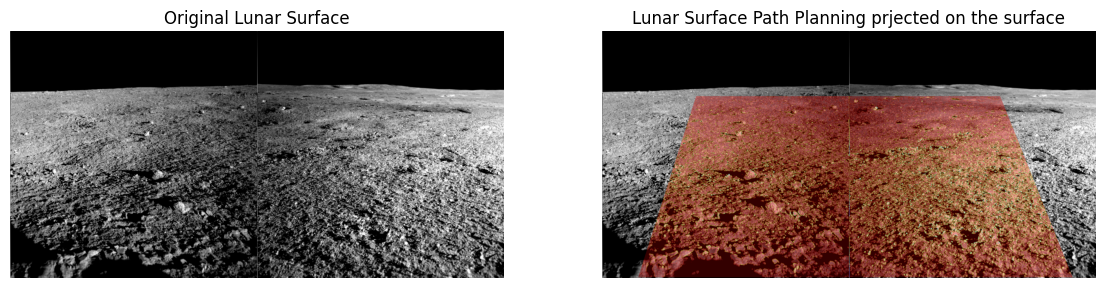

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the lunar surface image
image_path = r"D:\research_implementation\lunar_surface\merged_image.png"

image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not found. Check the path.")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ----------------------------------
# 1️⃣ Define Manually Selected Terrain Points
# ----------------------------------
terrain_points = np.array([
    [390, 270],  # Top-left
    [1650, 270],  # Top-right
    [1950, 1020],  # Bottom-right
    [150, 1020],  # Bottom-left
], dtype=np.float32)

# ----------------------------------
# 2️⃣ Define a Regular Grid for Mapping
# ----------------------------------
grid_width = 500
grid_height = 500

reference_grid = np.array([
    [0, 0],                # Top-left
    [grid_width, 0],       # Top-right
    [grid_width, grid_height],  # Bottom-right
    [0, grid_height]       # Bottom-left
], dtype=np.float32)

# Compute Homography
H, _ = cv2.findHomography(reference_grid, terrain_points)

# ----------------------------------
# 3️⃣ Compute Energy Map (Sobel Filter)
# ----------------------------------
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
energy_map = np.sqrt(sobel_x**2 + sobel_y**2)
energy_map = (energy_map / energy_map.max() * 255).astype(np.uint8)

# Create a blank mask for the homographic region
mask = np.zeros_like(image[:, :, 0])

# Warp the reference grid into the actual image
homographic_mask = np.array([terrain_points], dtype=np.int32)
cv2.fillPoly(mask, homographic_mask, 255)

# Apply mask to energy map
energy_masked = cv2.bitwise_and(energy_map, energy_map, mask=mask)

# Convert energy map to color for overlay
energy_colored = cv2.applyColorMap(energy_masked, cv2.COLORMAP_JET)

# ----------------------------------
# 4️⃣ Overlay Energy Map on Original Image
# ----------------------------------
overlay = image.copy()
overlay[mask > 0] = cv2.addWeighted(image, 0.6, energy_colored, 0.4, 0)[mask > 0]

# ----------------------------------
# 5️⃣ Show Results
# ----------------------------------
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Original Image
ax[0].imshow(image)
ax[0].set_title("Original Lunar Surface")
ax[0].axis("off")

# Image with Energy Overlay
ax[1].imshow(overlay)
ax[1].set_title("Lunar Surface Path Planning prjected on the surface")
ax[1].axis("off")

plt.show()



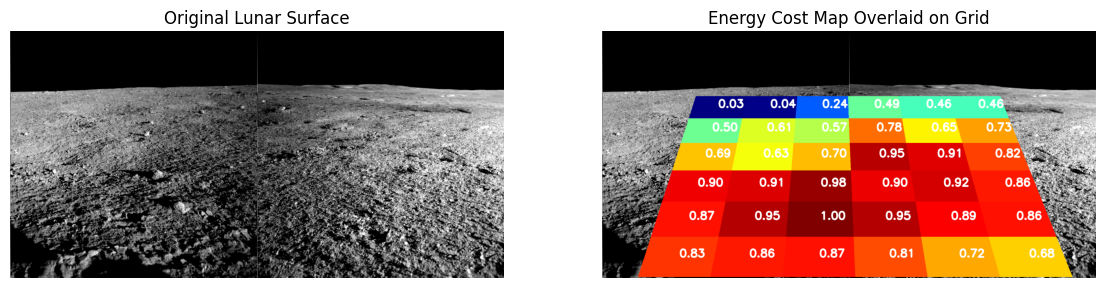

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the lunar surface image
image_path = r"D:\research_implementation\lunar_surface\merged_image.png"

image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not found. Check the path.")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ------------------------------
# 1️⃣ Define Manually Selected Terrain Points
# ------------------------------
terrain_points = np.array([
    [390, 270],  # Top-left
    [1650, 270],  # Top-right
    [1950, 1020],  # Bottom-right
    [150, 1020],  # Bottom-left
], dtype=np.float32)

# ------------------------------
# 2️⃣ Define a Regular Grid for Mapping
# ------------------------------
grid_size = 6  # Grid resolution
grid_width = 500
grid_height = 500

reference_grid = np.array([
    [0, 0],               # Top-left
    [grid_width, 0],      # Top-right
    [grid_width, grid_height],  # Bottom-right
    [0, grid_height]      # Bottom-left
], dtype=np.float32)

# Compute Homography
H, status = cv2.findHomography(reference_grid, terrain_points)
if H is None:
    raise ValueError("Homography computation failed.")

# ------------------------------
# 3️⃣ Define Energy Cost Values (6x6 Grid)
# ------------------------------
energy_cost = np.array([
    [0.831, 0.859, 0.867, 0.807, 0.722, 0.682],
    [0.867, 0.951, 1.000, 0.952, 0.886, 0.864],
    [0.895, 0.913, 0.978, 0.898, 0.924, 0.857],
    [0.693, 0.632, 0.703, 0.950, 0.910, 0.818],
    [0.502, 0.606, 0.569, 0.778, 0.650, 0.729],
    [0.033, 0.042, 0.243, 0.494, 0.463, 0.463]
])
energy_cost = np.flip(energy_cost,0)

# Normalize energy cost to range [0, 255]
energy_colormap = (energy_cost - energy_cost.min()) / (energy_cost.max() - energy_cost.min()) * 255
energy_colormap = energy_colormap.astype(np.uint8)
energy_colormap = cv2.applyColorMap(energy_colormap, cv2.COLORMAP_JET)

# ------------------------------
# 4️⃣ Project and Overlay the Energy Map on the Grid
# ------------------------------
overlay = image.copy()

cell_w = grid_width / grid_size
cell_h = grid_height / grid_size

for i in range(grid_size):
    for j in range(grid_size):
        # Compute four corners of each grid cell in reference frame
        ref_cell = np.array([
            [j * cell_w, i * cell_h, 1],
            [(j + 1) * cell_w, i * cell_h, 1],
            [(j + 1) * cell_w, (i + 1) * cell_h, 1],
            [j * cell_w, (i + 1) * cell_h, 1]
        ]).T  # Transpose for dot product

        # Transform to image space
        warped_cell = np.dot(H, ref_cell)
        warped_cell /= warped_cell[2]  # Normalize

        # Convert to integer pixel coordinates
        pts = np.int32(warped_cell[:2].T)

        # Fill grid cell with corresponding energy colormap value
        color = tuple(int(c) for c in energy_colormap[i, j, ::-1])  # Convert BGR to RGB
        cv2.fillPoly(overlay, [pts], color)

        # Write Energy Value
        center_x, center_y = np.mean(pts, axis=0).astype(int)
        cv2.putText(overlay, f"{energy_cost[i, j]:.2f}", (center_x, center_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 5, cv2.LINE_AA)

# ------------------------------
# 5️⃣ Show Results
# ------------------------------
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Original Image with Grid
ax[0].imshow(image)
ax[0].set_title("Original Lunar Surface")
ax[0].axis("off")

# Image with Energy Overlay
ax[1].imshow(overlay)
ax[1].set_title("Energy Cost Map Overlaid on Grid")
ax[1].axis("off")

plt.show()


[[ 10.           0.95722287   0.75688337   0.50529766   0.53631406
    0.53620103]
 [  0.49776473   0.39352879   0.43008327   0.22109865   0.34912538
    0.27001325]
 [  0.30642191   0.36748134   0.29666499 -10.         -10.
    0.18104589]
 [  0.10455198 -10.         -10.           0.10155803 -10.
    0.14289605]
 [  0.1322594  -10.         -10.         -10.           0.11316908
    0.13566125]
 [  0.16879335   0.14095352   0.13259358   0.19214915   0.27778908
    0.3178571 ]]


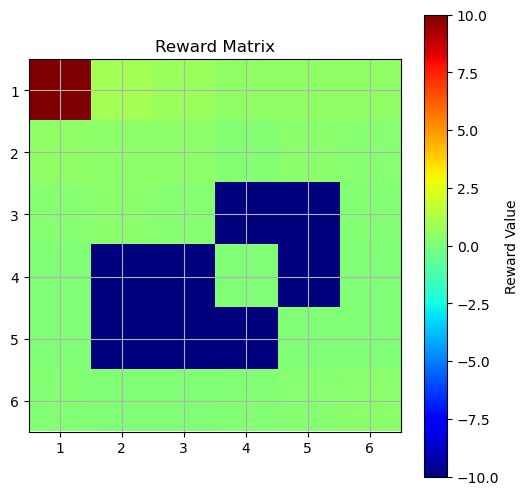

In [67]:
import numpy as np
import random
import matplotlib.pyplot as plt

# # 6x6 Energy Cost Matrix
energy_cost = np.array([
    [0.83120665, 0.85904648, 0.86740642, 0.80785085, 0.72221092, 0.6821429],
    [0.8677406, 0.95105498, 1., 0.95264647, 0.88683092, 0.86433875],
    [0.89544802, 0.91301993, 0.97772431, 0.89844197, 0.92461879, 0.85710395],
    [0.69357809, 0.63251866, 0.70333501, 0.95006792, 0.91024824, 0.81895411],
    [0.50223527, 0.60647121, 0.56991673, 0.77890135, 0.65087462, 0.72998675],
    [0., 0.04277713, 0.24311663, 0.49470234, 0.46368594, 0.46379897]
])
energy_cost = np.flip(energy_cost, 0)
# Convert energy cost to reward (lower energy = higher reward)
# map obstacle when energy is < 0.95
reward_matrix = 1 - energy_cost
for i in range(5):
    for j in range(5):
        if energy_cost[i, j] > 0.90:
            reward_matrix[i, j] = -10

reward_matrix[0, 0] = 10

print(reward_matrix)
# -------------------------
# **Step 2: Generate Reward Map**
# -------------------------
plt.figure(figsize=(6,6))
plt.imshow(reward_matrix, cmap='jet', interpolation='nearest')
plt.colorbar(label="Reward Value")
plt.title("Reward Matrix")
plt.xticks(np.arange(6), labels=[1,2,3,4,5,6])
plt.yticks(np.arange(6), labels=[1,2,3,4,5,6])
plt.grid()
plt.show()

In [68]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Define actions (Up, Down, Left, Right)
actions = np.array([
    [-1, 0],  # Up
    [1, 0],   # Down
    [0, -1],  # Left
    [0, 1],   # Right
    [1, 1],   # Diagonal Down-Right
    [-1, -1], # Diagonal Up-Left
    [1, -1],  # Diagonal Down-Left
    [-1, 1]   # Diagonal Up-Right
])

# Q-table initialization (6x6 grid, 4 actions)
q_table = np.zeros((6, 6, len(actions)))

 

# Hyperparameters
alpha = 0.01   # Learning rate
gamma = 0.9    # Discount factor
epsilon = 1.0  # Exploration rate
decay = 0.99   # Decay rate for exploration
episodes = 100

# Start and Goal states
start_state = np.array([5, 5])  # (1,1) in grid
goal_state = np.array([0, 0])   # (6,6) in grid



In [69]:
# Q-learning Algorithm
for episode in range(episodes):
    state = start_state.copy()
    
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1}/{episodes}")

    while not np.array_equal(state, goal_state):
        # Choose action using ε-greedy policy (vectorized selection)
        if random.random() < epsilon:
            action = np.random.randint(len(actions))  # Ensure dynamic action space
        else:
            action = np.argmax(q_table[state[0], state[1]])  # Exploit best action

        # Get next state with boundary constraints
        next_state = np.clip(state + actions[action], 0, 5)

        # Get reward
        reward = reward_matrix[next_state[0], next_state[1]]

        # Update Q-table using Bellman equation
        q_table[state[0], state[1], action] = (
            (1 - alpha) * q_table[state[0], state[1], action] +
            alpha * (reward + gamma * np.max(q_table[next_state[0], next_state[1]]))
        )

        # Move to next state
        state = next_state.copy()  # Ensure proper state update

    # Decay epsilon
    epsilon *= decay

print("Training Complete! 🚀")
print(q_table)


Episode 10/100
Episode 20/100
Episode 30/100
Episode 40/100
Episode 50/100
Episode 60/100
Episode 70/100
Episode 80/100
Episode 90/100
Episode 100/100
Training Complete! 🚀
[[[ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.05052857  0.16019422  2.96552305  0.12844458  0.04921812
    0.67934652  0.08540224  0.02854603]
  [ 0.11782177  0.01822823  1.04989485  0.05696085  0.05218534
    0.2306782   0.11862148  0.08976325]
  [ 0.03991831  0.02551747  0.51570858  0.03629735  0.04076687
    0.10351506  0.0567609   0.06930968]
  [ 0.05104909  0.03563992  0.00623748  0.02855553  0.03061495
    0.2269978   0.01698205  0.05057289]
  [ 0.02302513  0.01741974  0.10609614  0.03901676  0.01505953
    0.02299263  0.03866504  0.00615369]]

 [[ 1.9836941   0.01349691  0.03530841  0.10523622  0.05255263
    0.1         0.02295768  0.08513755]
  [ 0.05911812  0.0438476   0.05967856  0.02427966  0.02854569
    2.96552305  0.02694023  0.08154956]
  [ 0.2117

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define Grid and Colors
grid_size = 6
path_grid = np.zeros((grid_size, grid_size))

# Start and Goal State
state = start_state.copy()
path_grid[state[0], state[1]] = 1  # Mark start position

# Extract Optimal Path from Q-Table
while not np.array_equal(state, goal_state):
    action = np.argmax(q_table[state[0], state[1]])
    next_state = np.clip(state + actions[action], 0, 5)
    
    path_grid[next_state[0], next_state[1]] = 2  # Mark Path
    state = next_state.copy()

# Plot the Grid with Path
plt.figure(figsize=(6,6))
plt.imshow(path_grid, cmap="coolwarm", origin="upper")

# Mark Start and Goal
plt.text(start_state[1], start_state[0], 'S', ha='center', va='center', fontsize=12, fontweight='bold', color='white')
plt.text(goal_state[1], goal_state[0], 'G', ha='center', va='center', fontsize=12, fontweight='bold', color='white')

# Add Grid Lines
plt.xticks(range(grid_size))
plt.yticks(range(grid_size))
plt.grid(True, linestyle="--", color="black", linewidth=0.5)
plt.title("Optimal Path Learned by Q-learning")
plt.show()


In [ ]:
# # using cupy for gpu acceration

# import cupy as cp
# import random

# # Hyperparameters
# episodes = 1000
# alpha = 0.01    # Learning rate
# gamma = 0.99    # Discount factor
# epsilon = 1.0  # Exploration rate
# decay = 0.99   # Epsilon decay factor

# # Action space (Up, Down, Left, Right, and Diagonals)
# actions = cp.array([
#     [-1, 0],  # Up
#     [1, 0],   # Down
#     [0, -1],  # Left
#     [0, 1],   # Right
#     [1, 1],   # Diagonal Down-Right
#     [-1, -1], # Diagonal Up-Left
#     [1, -1],  # Diagonal Down-Left
#     [-1, 1]   # Diagonal Up-Right
# ])

# # Q-table initialized on GPU
# q_table = cp.zeros((6, 6, 8), dtype=cp.float32)  # Shape: (rows, cols, actions)

# # Reward matrix (GPU-based)
# reward_matrix = cp.array([
#     [10, 0.95,  0.75,  0.50,  0.53,  0.53],
#     [0.49, 0.39, 0.43,  0.22,  0.34,  0.27],
#     [0.30, 0.36, 0.29, -10,   -10,   0.18],
#     [0.10, -10,  -10,   0.10, -10,   0.14],
#     [0.13, -10,  -10,  -10,    0.11,  0.13],
#     [0.16, 0.14,  0.13,  0.19,  0.27,  0.31]
# ], dtype=cp.float32)

# # Start & Goal state
# start_state = cp.array([0, 0])
# goal_state = cp.array([5, 5])

# # Q-learning Algorithm
# for episode in range(episodes):
#     state = start_state.copy()

#     if (episode + 1) % 10 == 0:
#         print(f"Episode {episode + 1}/{episodes}")

#     while not cp.array_equal(state, goal_state):
#         # Choose action using ε-greedy policy
#         if random.random() < epsilon:
#             action = cp.random.randint(8)  # Explore randomly
#         else:
#             action = cp.argmax(q_table[state[0], state[1]])  # Exploit best action

#         # Get next state with boundary constraints
#         next_state = cp.clip(state + actions[action], 0, 5)

#         # Check if the next state is an obstacle (-10 reward)
#         if reward_matrix[next_state[0], next_state[1]] == -10:
#             continue  # Skip and retry another action

#         # Get reward
#         reward = reward_matrix[next_state[0], next_state[1]]

#         # Update Q-table using Bellman equation (GPU-accelerated)
#         q_table[state[0], state[1], action] = (
#             (1 - alpha) * q_table[state[0], state[1], action] +
#             alpha * (reward + gamma * cp.max(q_table[next_state[0], next_state[1]]))
#         )

#         # Move to next state
#         state = next_state

#     # Decay epsilon
#     epsilon *= decay

# print("Training Complete! 🚀")

# # Move Q-table to CPU for printing
# print(cp.asnumpy(q_table))


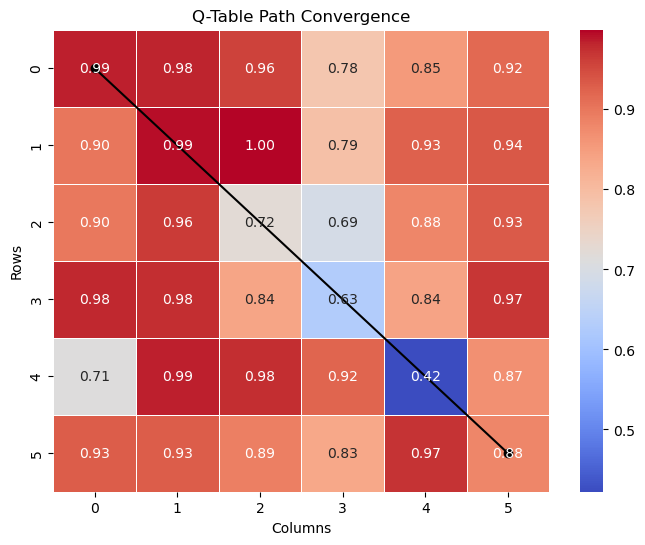

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define action space (8 possible movements)
actions = np.array([
    [-1, 0],  # Up
    [1, 0],   # Down
    [0, -1],  # Left
    [0, 1],   # Right
    [1, 1],   # Diagonal Down-Right
    [-1, -1], # Diagonal Up-Left
    [1, -1],  # Diagonal Down-Left
    [-1, 1]   # Diagonal Up-Right
])

# Get optimal path using NumPy
def get_optimal_path(q_table, actions):
    path = []
    row, col = 5, 5  # Start at (5,5)
    goal = (0, 0)  # Goal at (0,0)

    while (row, col) != goal:
        path.append((row, col))
        action = np.argmax(q_table[:, row, col])  # Get the best action

        # Compute next position
        new_row = row + actions[action, 0]
        new_col = col + actions[action, 1]

        # Ensure movement stays within bounds (0 to 5)
        if 0 <= new_row <= 5 and 0 <= new_col <= 5:
            row, col = int(new_row), int(new_col)  # Convert from NumPy to Python int
        else:
            break  # Stop if no valid move

    path.append(goal)  # Append goal state
    return path

# Example Q-table (random values for demonstration)
q_table = np.random.rand(8, 6, 6)

# Get optimal path
optimal_path = get_optimal_path(q_table, actions)

# Move data to CPU for visualization
q_table_cpu = np.max(q_table, axis=0)

# Visualize Path Convergence
plt.figure(figsize=(8, 6))
sns.heatmap(q_table_cpu, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Q-Table Path Convergence')
plt.xlabel('Columns')
plt.ylabel('Rows')

# Plot path
path_rows, path_cols = zip(*optimal_path)
plt.plot(np.array(path_cols) + 0.5, 
         np.array(path_rows) + 0.5, 
         marker='o', color='black', linestyle='-')

plt.show()


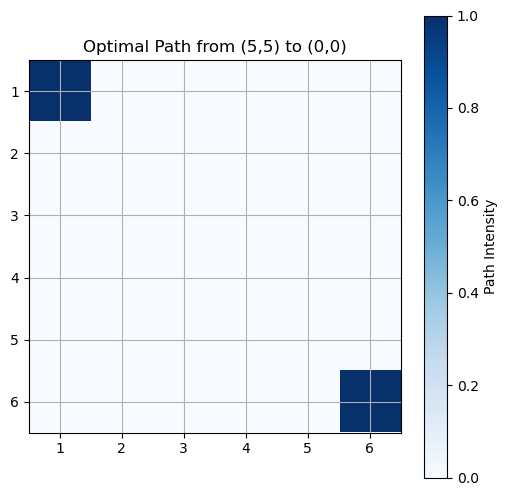

In [50]:
path = optimal_path
# Visualize optimal path
path_matrix = np.zeros((6,6))
for (x,y) in path:
    path_matrix[x,y] = 1  # Mark path cells

plt.figure(figsize=(6,6))
plt.imshow(path_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar(label="Path Intensity")
plt.title("Optimal Path from (5,5) to (0,0)")
plt.xticks(np.arange(6), labels=[1,2,3,4,5,6])
plt.yticks(np.arange(6), labels=[1,2,3,4,5,6])
plt.grid()
plt.show()


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import cv2

# Load the lunar surface image
image_path = "D:\\research_implementation\\lunar_surface\\merged_image.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define grid size
grid_size = 6

# Define manually selected terrain points for homography
terrain_points = np.array([
    [390, 270],  # Top-left
    [1650, 270],  # Top-right
    [1950, 1020],  # Bottom-right
    [150, 1020],  # Bottom-left
], dtype=np.float32)

# Define a Regular Grid for Mapping
grid_width = 500
grid_height = 500
reference_grid = np.array([
    [0, 0],               # Top-left
    [grid_width, 0],      # Top-right
    [grid_width, grid_height],  # Bottom-right
    [0, grid_height]      # Bottom-left
], dtype=np.float32)

# Compute Homography
H, status = cv2.findHomography(reference_grid, terrain_points)
if H is None:
    raise ValueError("Homography computation failed.")

# Define energy cost as the negative reward (so the agent minimizes cost)
energy_cost = np.array([
    [0.8312, 0.8590, 0.8674, 0.8078, 0.7222, 0.6821],
    [0.8677, 0.9510, 1.0000, 0.9526, 0.8868, 0.8643],
    [0.8954, 0.9130, 0.9777, 0.8984, 0.9246, 0.8571],
    [0.6935, 0.6325, 0.7033, 0.9500, 0.9102, 0.8189],
    [0.5022, 0.6064, 0.5699, 0.7789, 0.6508, 0.7299],
    [0.0000, 0.0427, 0.2431, 0.4947, 0.4636, 0.4637]
])
energy_cost = np.flip(energy_cost, 0)

# Normalize energy cost to range [0, 255]
energy_colormap = (energy_cost - energy_cost.min()) / (energy_cost.max() - energy_cost.min()) * 255
energy_colormap = energy_colormap.astype(np.uint8)
energy_colormap = cv2.applyColorMap(energy_colormap, cv2.COLORMAP_JET)

# Overlay path and homographic grid on image
overlay = image.copy()
cell_w = grid_width / grid_size
cell_h = grid_height / grid_size

for i in range(grid_size + 1):
    try:
        # Vertical lines
        pt1 = np.dot(H, np.array([i * cell_w, 0, 1]))
        pt2 = np.dot(H, np.array([i * cell_w, grid_height, 1]))
        pt1 = (int(pt1[0] / pt1[2]), int(pt1[1] / pt1[2]))
        pt2 = (int(pt2[0] / pt2[2]), int(pt2[1] / pt2[2]))
        cv2.line(overlay, pt1, pt2, (255, 255, 255), 2)

        # Horizontal lines
        pt3 = np.dot(H, np.array([0, i * cell_h, 1]))
        pt4 = np.dot(H, np.array([grid_width, i * cell_h, 1]))
        pt3 = (int(pt3[0] / pt3[2]), int(pt3[1] / pt3[2]))
        pt4 = (int(pt4[0] / pt4[2]), int(pt4[1] / pt4[2]))
        cv2.line(overlay, pt3, pt4, (255, 255, 255), 2)
    except:
        print(f"Skipping line {i} due to invalid transformation.")

# Dummy optimal path
# optimal_path = [(0, 0), (1, 0),  (1, 1), (2, 2), (3, 3), (4, 4), (4, 5),(5,5)]

# Transform and draw the path on the homographic grid
path_points = []
for (x, y) in optimal_path:
    pt = np.dot(H, np.array([y * cell_w, x * cell_h, 1]))
    pt = (int(pt[0] / pt[2]), int(pt[1] / pt[2]))
    path_points.append(pt)

for i in range(len(path_points) - 1):
    cv2.line(overlay, path_points[i], path_points[i + 1], (0, 255, 0), 3)  # Green path

# Visualize overlay
plt.figure(figsize=(8, 6))
plt.imshow(overlay)
plt.title("Energy Cost Map with Homographic Grid and Optimal Path Overlay on Lunar Surface")
plt.axis("off")
plt.show()

[ WARN:0@295.786] global loadsave.cpp:241 findDecoder imread_('D:\research_implementation\lunar_surface\merged_image.png'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /croot/opencv-suite_1738943342777/work/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
